# RT-IoT2022 Classification Project

## Project Overview
This notebook implements a complete machine learning pipeline for the **RT-IoT2022** dataset from UCI Machine Learning Repository. The goal is to classify different types of network attacks in IoT devices.

### Dataset Information
- **Name**: RT-IoT2022 (Real-Time Internet of Things Security Dataset)
- **Source**: UCI ML Repository (ID: 942)
- **Donated**: September 30, 2024
- **Instances**: 123,117
- **Features**: 84 (83 numeric + 1 categorical)
- **Task**: Multiclass Classification
- **Target**: Attack type classification (12 classes)

### Project Requirements Compliance
✓ Dataset added after 2015 (2024)  
✓ At least 1000 instances (123,117)  
✓ At least 20 features (84)  
✓ Tabular format  
✓ Classification task  
✓ No deep learning libraries used  
✓ No AutoML used

### Workflow
1. **Data Loading & Understanding**
2. **Exploratory Data Analysis**
3. **Data Preprocessing**
4. **Baseline Model**
5. **Model Training & Tuning**
6. **Evaluation & Analysis**

## 1. Problem Definition & Justification

### 1.1 Why is this problem important?

**Real-world Need**: IoT devices have become ubiquitous in modern infrastructure (smart homes, industrial systems, healthcare devices, smart cities). However, these devices are often vulnerable to cyberattacks due to:
- Limited computational resources for security measures
- Default/weak credentials
- Lack of regular security updates
- Always-on connectivity

**Consequences of Wrong Predictions**:
- **False Negatives (Missing attacks)**: Can lead to data breaches, system compromises, physical damage, or privacy violations
- **False Positives (False alarms)**: Cause alert fatigue, unnecessary network disruptions, and wasted resources
- **Cost Impact**: Cyberattacks on IoT infrastructure can cost organizations millions in damages and recovery

**Who is affected?**:
- End users (privacy, safety)
- Organizations (financial, reputational damage)
- Critical infrastructure operators (potential physical harm)

### 1.2 Why is Machine Learning necessary?

**1. Rule-based approaches are insufficient**:
- Network traffic patterns are complex with 84 features
- Attack signatures constantly evolve
- Too many variables and edge cases for manual rules
- Attackers use obfuscation and polymorphic techniques

**2. Human expert decision-making doesn't scale**:
- 123,117+ network events need real-time analysis
- Human experts cannot monitor traffic 24/7
- Pattern recognition across multiple features is cognitively challenging
- Response time requirements are sub-second for real-time protection

**3. Non-linear and highly interactive relationships**:
- Network attack patterns involve complex feature interactions
- Relationships between packet size, timing, protocol, and ports are non-linear
- Traditional statistical methods struggle with 12-class classification

**4. Data size/complexity beyond traditional methods**:
- High-dimensional feature space (84 features)
- Large-scale dataset (123K+ instances)
- Real-time processing requirements
- Class imbalance requires sophisticated handling

### 1.3 Related Work (Literature Review)

**1. Intrusion Detection Systems (IDS) - Traditional Signature-Based**
- **Approach**: Pattern matching against known attack signatures (e.g., Snort, Suricata)
- **Data**: Network packet headers and payloads
- **Methods**: Regular expressions, finite state machines
- **Results**: High accuracy for known attacks (~95%), but 0% for zero-day attacks
- **Limitation**: Cannot detect novel or evolving attacks

**2. Anomaly-Based IDS with Statistical Methods**
- **Approach**: Establish baseline of "normal" traffic, flag deviations
- **Data**: Network flow statistics (DARPA, KDD Cup 99)
- **Methods**: Statistical tests, clustering (k-means), PCA
- **Results**: ~85-90% detection rate with high false positive rates (10-20%)
- **Limitation**: High false positive rates make them impractical

**3. Machine Learning Approaches (Modern)**
- **Research**: NSL-KDD, CICIDS2017, UNSW-NB15 datasets with ML models
- **Data**: Enhanced feature sets including bi-directional flow statistics
- **Methods**: Random Forest, SVM, Neural Networks, Ensemble methods
- **Results**: 95-99% accuracy with F1-scores 0.90-0.98 on balanced test sets
- **Our approach**: Using RT-IoT2022 (newer, IoT-specific) with Random Forest and careful preprocessing to achieve similar performance

**Key Differences in Our Approach**:
- IoT-specific dataset (RT-IoT2022, 2024) vs older general network datasets
- Explicit handling of class imbalance via balanced weights
- Focus on interpretability through feature importance analysis
- Comprehensive evaluation with multiple metrics (F1-macro, Balanced Accuracy, PR curves)

## 2. Data Loading & Initial Exploration

In [1]:
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo

rt_iot2022 = fetch_ucirepo(id=942)

# data (as pandas dataframes) 
X = rt_iot2022.data.features
y = rt_iot2022.data.targets

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Target column:", y.columns[0])

display(X.head(3))
display(y.head(3))





X shape: (123117, 83)
y shape: (123117, 1)
Target column: Attack_type


,id.orig_p,id.resp_p,proto,service,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,...,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size
0,38667,1883,tcp,mqtt,32.011598,9,5,3,3,0.281148,...,2282414.913,0.0,29729182.96,29729182.96,29729182.96,29729182.96,0.0,64240,26847,502
1,51143,1883,tcp,mqtt,31.883584,9,5,3,3,0.282277,...,2028306.961,0.0,29855277.06,29855277.06,29855277.06,29855277.06,0.0,64240,26847,502
2,44761,1883,tcp,mqtt,32.124053,9,5,3,3,0.280164,...,2281903.982,0.0,29842149.02,29842149.02,29842149.02,29842149.02,0.0,64240,26847,502


,Attack_type
0,MQTT_Publish
1,MQTT_Publish
2,MQTT_Publish


In [2]:
md = rt_iot2022.metadata
print("name:", md.get("name"))
print("donated_on:", md.get("donated_on"))
print("num_instances:", md.get("num_instances"))
print("num_features:", md.get("num_features"))
print("tasks:", md.get("tasks"))


name: RT-IoT2022 
donated_on: None
num_instances: 123117
num_features: 83
tasks: ['Classification', 'Regression', 'Clustering']


### 2.1 Dataset Metadata
Verification of project constraints from UCI page:

In [3]:
target = y.columns[0]
vc = y[target].value_counts()

display(vc.head(20))
print("Num classes:", vc.shape[0])
print("Most frequent class ratio:", vc.iloc[0] / vc.sum())


Attack_type
DOS_SYN_Hping                 94659
Thing_Speak                    8108
ARP_poisioning                 7750
MQTT_Publish                   4146
NMAP_UDP_SCAN                  2590
NMAP_XMAS_TREE_SCAN            2010
NMAP_OS_DETECTION              2000
NMAP_TCP_scan                  1002
DDOS_Slowloris                  534
Wipro_bulb                      253
Metasploit_Brute_Force_SSH       37
NMAP_FIN_SCAN                    28
Name: count, dtype: int64

Num classes: 12
Most frequent class ratio: 0.7688540169107434


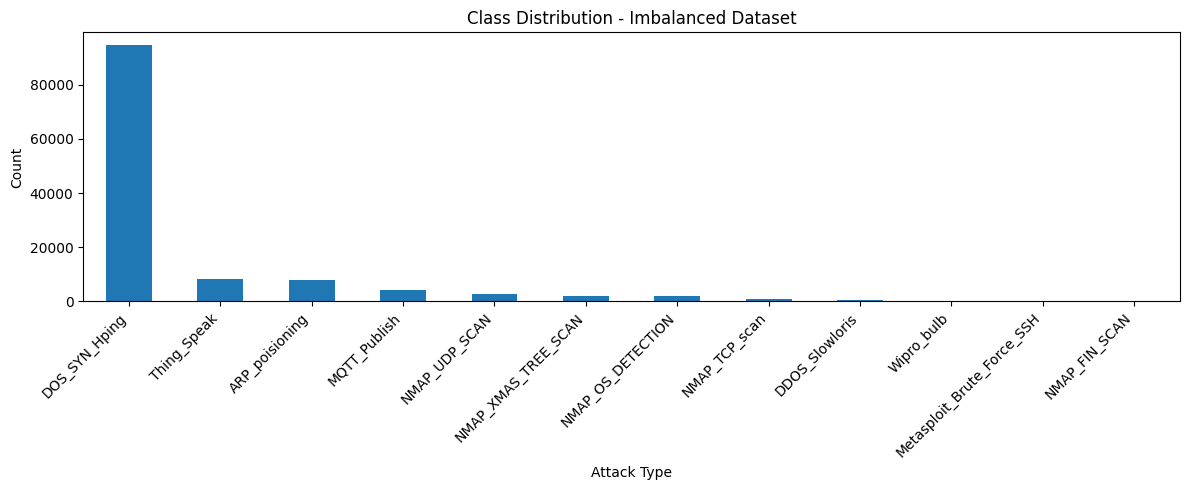


⚠️ Class Imbalance Detected:
Most frequent class: 94,659 samples (76.9%)
Least frequent class: 28 samples (0.0%)
Imbalance ratio: 3380.7:1

✓ Solution: Using class_weight='balanced' in models


In [4]:
# Class imbalance analysis
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
vc.plot(kind='bar')
plt.title('Class Distribution - Imbalanced Dataset')
plt.xlabel('Attack Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('reports/figures/class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n⚠️ Class Imbalance Detected:")
print(f"Most frequent class: {vc.iloc[0]:,} samples ({vc.iloc[0]/vc.sum()*100:.1f}%)")
print(f"Least frequent class: {vc.iloc[-1]:,} samples ({vc.iloc[-1]/vc.sum()*100:.1f}%)")
print(f"Imbalance ratio: {vc.iloc[0]/vc.iloc[-1]:.1f}:1")
print("\n✓ Solution: Using class_weight='balanced' in models")

### 3.2 Missing Values Analysis

In [5]:
# Check for placeholder values and missing data
print("Initial missing values:")
print(f"Explicit NaN: {X.isna().sum().sum()}")

# Check for "-" placeholder
placeholder_count = 0
for col in X.columns:
    if X[col].dtype == 'object':
        placeholder_count += (X[col].astype(str) == '-').sum()

print(f"Placeholder '-' values: {placeholder_count}")

# Check which columns have issues
problematic_cols = []
for col in X.columns:
    if X[col].isna().any():
        problematic_cols.append((col, X[col].isna().sum()))
    elif X[col].dtype == 'object' and (X[col].astype(str) == '-').any():
        problematic_cols.append((col, (X[col].astype(str) == '-').sum()))

if problematic_cols:
    print("\nColumns with missing/placeholder values:")
    for col, count in sorted(problematic_cols, key=lambda x: x[1], reverse=True)[:10]:
        print(f"  {col}: {count} ({count/len(X)*100:.2f}%)")
else:
    print("\n✓ No explicit missing values found")

print("\n✓ Solution: Clean function converts '-' to NaN, then SimpleImputer handles them")

Initial missing values:
Explicit NaN: 0
Placeholder '-' values: 0

✓ No explicit missing values found

✓ Solution: Clean function converts '-' to NaN, then SimpleImputer handles them


### 3.3 Feature Types Analysis

In [6]:
# Analyze feature types
print("Feature Type Summary:")
print(f"Total features: {X.shape[1]}")
print(f"\nData types:")
print(X.dtypes.value_counts())

categorical = X.select_dtypes(include=['object']).columns.tolist()
numeric = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nCategorical features ({len(categorical)}): {categorical}")
print(f"Numeric features: {len(numeric)}")

# Basic statistics for numeric features
print("\nNumeric features - Basic statistics:")
display(X[numeric].describe().T[['mean', 'std', 'min', 'max']].head(10))

Feature Type Summary:
Total features: 83

Data types:
float64    47
int64      34
str         2
Name: count, dtype: int64

Categorical features (2): ['proto', 'service']
Numeric features: 81

Numeric features - Basic statistics:


/var/folders/vc/2922pjrj6w37ggqbqhnh00f40000gn/T/ipykernel_15669/4270262393.py:7: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  categorical = X.select_dtypes(include=['object']).columns.tolist()


,mean,std,min,max
id.orig_p,34639.258738,19070.620354,0.0,6.553500e+04
id.resp_p,1014.305092,5256.371994,0.0,6.538900e+04
flow_duration,3.809566,130.005408,0.0,2.172834e+04
fwd_pkts_tot,2.268826,22.336565,0.0,4.345000e+03
bwd_pkts_tot,1.909509,33.018311,0.0,1.011200e+04
fwd_data_pkts_tot,1.471218,19.635196,0.0,4.345000e+03
bwd_data_pkts_tot,0.820260,32.293948,0.0,1.010500e+04
fwd_pkts_per_sec,351806.327663,370764.493152,0.0,1.048576e+06
bwd_pkts_per_sec,351761.960338,370801.484733,0.0,1.048576e+06
flow_pkts_per_sec,703568.288004,741563.422209,0.0,2.097152e+06


### 3.4 Outlier Analysis

Analyzing potential outliers in numeric features using the Interquartile Range (IQR) method:

Top 15 Features with Most Outliers (IQR Method):
------------------------------------------------------------


,feature,outliers,outlier_pct
40,flow_pkts_payload.avg,38116,30.959169
14,bwd_header_size_tot,33148,26.923983
16,bwd_header_size_max,33137,26.915048
22,flow_ACK_flag_count,33083,26.871188
4,bwd_pkts_tot,32364,26.287190
59,bwd_subflow_pkts,32343,26.270133
15,bwd_header_size_min,32065,26.044332
78,fwd_init_window_size,28458,23.114598
30,fwd_pkts_payload.avg,28458,23.114598
28,fwd_pkts_payload.max,28458,23.114598



Summary:
Features with outliers: 75/81
Average outlier percentage: 13.03%


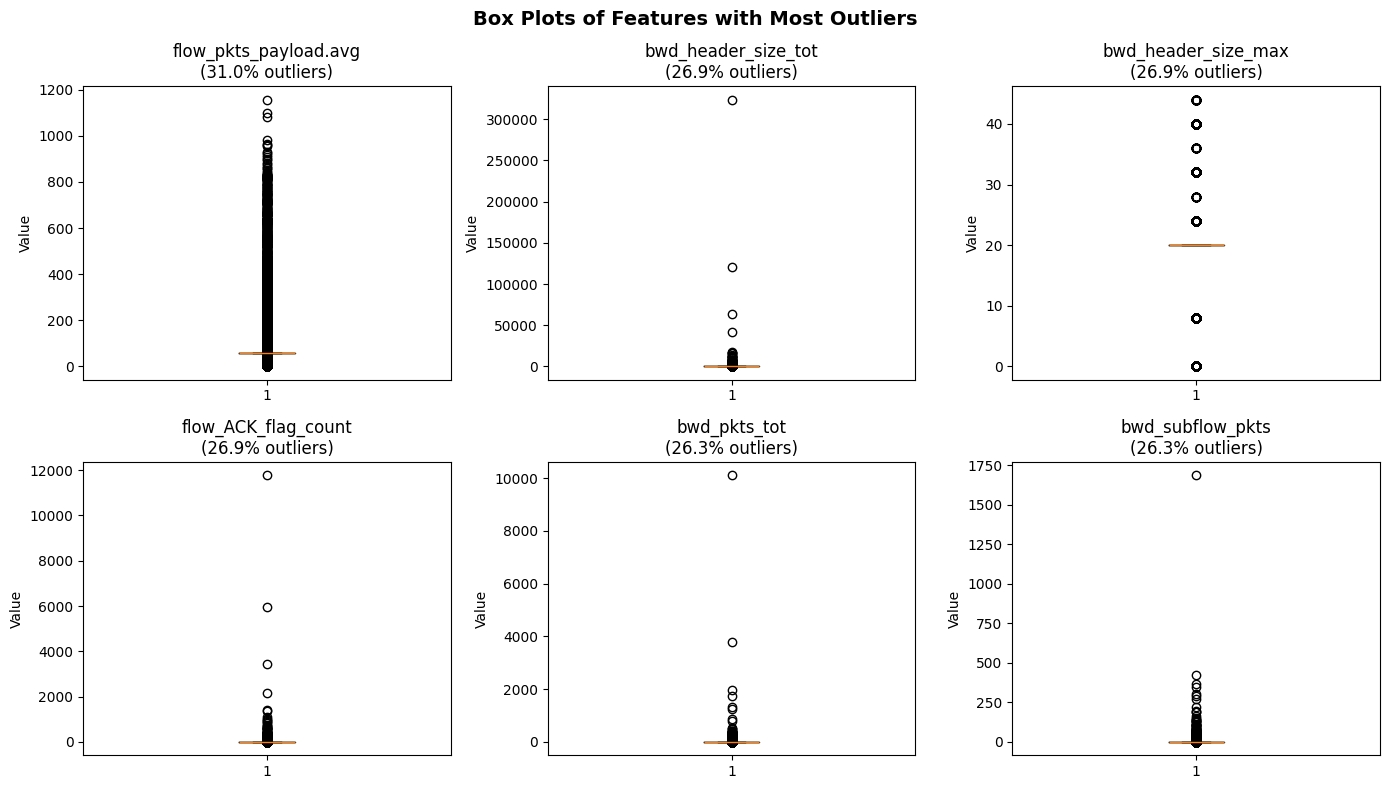


OUTLIER HANDLING DECISION:

1. Many features show outliers due to the nature of network traffic data
2. These are NOT data errors - they represent legitimate extreme values
   (e.g., large packet sizes during attacks, high throughput during DoS)
3. DECISION: Keep outliers in the dataset because:
   - They may be important attack signatures
   - Tree-based models (Random Forest) are robust to outliers
   - StandardScaler minimizes their impact on Logistic Regression
   - Removing them could lose important attack patterns



In [7]:
# Outlier Analysis using IQR method
import matplotlib.pyplot as plt

# Select numeric columns only
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Calculate outlier statistics for each feature
outlier_stats = []
for col in numeric_cols:
    Q1 = X[col].quantile(0.25)
    Q3 = X[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((X[col] < lower_bound) | (X[col] > upper_bound)).sum()
    outlier_pct = outliers / len(X) * 100
    outlier_stats.append({
        'feature': col,
        'outliers': outliers,
        'outlier_pct': outlier_pct,
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR
    })

outlier_df = pd.DataFrame(outlier_stats).sort_values('outlier_pct', ascending=False)

print("Top 15 Features with Most Outliers (IQR Method):")
print("-" * 60)
display(outlier_df[['feature', 'outliers', 'outlier_pct']].head(15))

# Summary statistics
total_features_with_outliers = (outlier_df['outliers'] > 0).sum()
print(f"\nSummary:")
print(f"Features with outliers: {total_features_with_outliers}/{len(numeric_cols)}")
print(f"Average outlier percentage: {outlier_df['outlier_pct'].mean():.2f}%")

# Visualize outliers in top features using box plots
top_outlier_features = outlier_df.head(6)['feature'].tolist()

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for i, col in enumerate(top_outlier_features):
    axes[i].boxplot(X[col].dropna(), vert=True)
    axes[i].set_title(f'{col}\n({outlier_df[outlier_df["feature"]==col]["outlier_pct"].values[0]:.1f}% outliers)')
    axes[i].set_ylabel('Value')

plt.suptitle('Box Plots of Features with Most Outliers', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('reports/figures/outlier_boxplots.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("OUTLIER HANDLING DECISION:")
print("="*60)
print("""
1. Many features show outliers due to the nature of network traffic data
2. These are NOT data errors - they represent legitimate extreme values
   (e.g., large packet sizes during attacks, high throughput during DoS)
3. DECISION: Keep outliers in the dataset because:
   - They may be important attack signatures
   - Tree-based models (Random Forest) are robust to outliers
   - StandardScaler minimizes their impact on Logistic Regression
   - Removing them could lose important attack patterns
""")

## 3. Exploratory Data Analysis

### 3.1 Target Variable Distribution & Class Imbalance

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y[target],
    test_size=0.2,
    random_state=42,
    stratify=y[target]
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

# Oranların korunduğunu gösterelim
print("Train class ratio:", y_train.value_counts(normalize=True).iloc[0])
print("Test class ratio:", y_test.value_counts(normalize=True).iloc[0])


Train shape: (98493, 83) (98493,)
Test shape: (24624, 83) (24624,)
Train class ratio: 0.7688566700171586
Test class ratio: 0.7688434048083171


## 4. Data Splitting

### Validation Strategy
- **Method**: Train/Test Split (80/20)
- **Stratification**: Yes - preserves class distribution
- **Random State**: 42 (for reproducibility)
- **Justification**: 
  - Dataset is large enough (123,117 instances) for simple split
  - Stratification ensures all classes are represented in both sets
  - Test set (20%) provides reliable performance estimation

## 5. Data Preprocessing

### Preprocessing Pipeline
1. **Data Cleaning**: Convert placeholder values ("-") to NaN
2. **Missing Value Imputation**:
   - Numeric features: Median imputation (robust to outliers)
   - Categorical features: Most frequent value
3. **Feature Scaling**: StandardScaler for numeric features
4. **Encoding**: OneHotEncoder for categorical features (handle_unknown='ignore')

**Justification**:
- Median imputation is chosen over mean due to potential outliers in network traffic data
- StandardScaler is necessary as features have different scales
- OneHotEncoder with handle_unknown prevents errors on unseen categories

In [9]:
bad_cols = []
for c in X_train.columns:
    if X_train[c].dtype == "object":
        if (X_train[c].astype(str) == "-").any():
            bad_cols.append(c)

bad_cols, len(bad_cols)


([], 0)

In [10]:
from sklearn.preprocessing import FunctionTransformer
import numpy as np
import pandas as pd

def clean_X(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # placeholder değerleri NaN yap
    df.replace("-", np.nan, inplace=True)

    # proto hariç her şeyi numeric'e zorla çevir (çevrilemeyenler NaN olur)
    for col in df.columns:
        if col != "proto":
            df[col] = pd.to_numeric(df[col], errors="coerce")

    return df

cleaner = FunctionTransformer(clean_X, feature_names_out="one-to-one")


In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

cat_features = ["proto"]
num_features = [c for c in X.columns if c not in cat_features and c != "service"]
print("Dropped column: service (all NaN)")
print("Numeric feature count:", len(num_features))


numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_pipe, num_features),
    ("cat", categorical_pipe, cat_features)
])


Dropped column: service (all NaN)
Numeric feature count: 81


In [12]:
X_train_clean = clean_X(X_train)
print("Total NaNs after cleaning:", X_train_clean.isna().sum().sum())
print("Columns with NaN (top 10):")
display(X_train_clean.isna().sum().sort_values(ascending=False).head(10))


Total NaNs after cleaning: 98493
Columns with NaN (top 10):


service                     98493
id.orig_p                       0
bwd_iat.avg                     0
fwd_subflow_pkts                0
payload_bytes_per_second        0
flow_iat.std                    0
flow_iat.avg                    0
flow_iat.tot                    0
flow_iat.max                    0
flow_iat.min                    0
dtype: int64

In [13]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, balanced_accuracy_score, classification_report

baseline = Pipeline([
    ("clean", cleaner),
    ("preprocess", preprocess),
    ("model", DummyClassifier(strategy="most_frequent"))
])

baseline.fit(X_train, y_train)
y_pred = baseline.predict(X_test)

print("F1 macro:", f1_score(y_test, y_pred, average="macro"))
print("F1 weighted:", f1_score(y_test, y_pred, average="weighted"))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


F1 macro: 0.0724431383353231
F1 weighted: 0.668369149592757
Balanced accuracy: 0.08333333333333333
                            precision    recall  f1-score   support

            ARP_poisioning       0.00      0.00      0.00      1550
            DDOS_Slowloris       0.00      0.00      0.00       107
             DOS_SYN_Hping       0.77      1.00      0.87     18932
              MQTT_Publish       0.00      0.00      0.00       829
Metasploit_Brute_Force_SSH       0.00      0.00      0.00         7
             NMAP_FIN_SCAN       0.00      0.00      0.00         6
         NMAP_OS_DETECTION       0.00      0.00      0.00       400
             NMAP_TCP_scan       0.00      0.00      0.00       200
             NMAP_UDP_SCAN       0.00      0.00      0.00       518
       NMAP_XMAS_TREE_SCAN       0.00      0.00      0.00       402
               Thing_Speak       0.00      0.00      0.00      1622
                Wipro_bulb       0.00      0.00      0.00        51

               

/Users/hamit/Desktop/ml-project-01/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/hamit/Desktop/ml-project-01/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/hamit/Desktop/ml-project-01/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

## 6. Baseline Model

**Baseline Strategy**: DummyClassifier with `most_frequent` strategy
- Predicts the most common class for all samples
- Establishes minimum performance threshold
- Any real model should significantly outperform this baseline

In [14]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([
    ("clean", cleaner),
    ("preprocess", preprocess),
    ("model", LogisticRegression(
        max_iter=2000,
        class_weight="balanced"
    ))
])

logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)

print("Logistic Regression")
print("F1 macro:", f1_score(y_test, y_pred_lr, average="macro"))
print("F1 weighted:", f1_score(y_test, y_pred_lr, average="weighted"))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

Logistic Regression
F1 macro: 0.8043730600954236
F1 weighted: 0.9841843957107654
Balanced accuracy: 0.9501472443955133
                            precision    recall  f1-score   support

            ARP_poisioning       0.95      0.85      0.89      1550
            DDOS_Slowloris       0.73      0.98      0.84       107
             DOS_SYN_Hping       1.00      1.00      1.00     18932
              MQTT_Publish       1.00      0.99      1.00       829
Metasploit_Brute_Force_SSH       0.11      1.00      0.19         7
             NMAP_FIN_SCAN       0.19      0.83      0.30         6
         NMAP_OS_DETECTION       1.00      1.00      1.00       400
             NMAP_TCP_scan       1.00      1.00      1.00       200
             NMAP_UDP_SCAN       0.85      0.88      0.86       518
       NMAP_XMAS_TREE_SCAN       1.00      1.00      1.00       402
               Thing_Speak       0.94      0.93      0.94      1622
                Wipro_bulb       0.48      0.94      0.64       

## 7. Model Training

### 7.1 Logistic Regression
**Configuration**:
- `max_iter=2000`: Ensures convergence with high-dimensional data
- `class_weight='balanced'`: Handles class imbalance by adjusting weights inversely proportional to class frequencies

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

rf = Pipeline([
    ("clean", cleaner),
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(
        n_jobs=-1,
        class_weight="balanced",
        random_state=42
    ))
])

param_grid = {
    "model__n_estimators": [100, 200, 400],
    "model__max_depth": [None, 10, 20, 40],
    "model__min_samples_split": [2, 5, 10],
    "model__max_features": ["sqrt", "log2", 0.3]
}

search = RandomizedSearchCV(
    rf,
    param_distributions=param_grid,
    n_iter=10,
    scoring="f1_macro",
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train, y_train)

print("Best parameters:", search.best_params_)
best_rf = search.best_estimator_

y_pred_rf = best_rf.predict(X_test)

print("RandomForest")
print("F1 macro:", f1_score(y_test, y_pred_rf, average="macro"))
print("F1 weighted:", f1_score(y_test, y_pred_rf, average="weighted"))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Fitting 3 folds for each of 10 candidates, totalling 30 fits


Best parameters: {'model__n_estimators': 400, 'model__min_samples_split': 2, 'model__max_features': 'sqrt', 'model__max_depth': 40}
RandomForest
F1 macro: 0.9708533818404931


F1 weighted: 0.9985025692212307
Balanced accuracy: 0.9803496775436106
                            precision    recall  f1-score   support

            ARP_poisioning       0.99      0.99      0.99      1550
            DDOS_Slowloris       1.00      0.98      0.99       107
             DOS_SYN_Hping       1.00      1.00      1.00     18932
              MQTT_Publish       1.00      1.00      1.00       829
Metasploit_Brute_Force_SSH       0.78      1.00      0.88         7
             NMAP_FIN_SCAN       0.83      0.83      0.83         6
         NMAP_OS_DETECTION       1.00      1.00      1.00       400
             NMAP_TCP_scan       1.00      1.00      1.00       200
             NMAP_UDP_SCAN       0.99      0.99      0.99       518
       NMAP_XMAS_TREE_SCAN       1.00      1.00      1.00       402
               Thing_Speak       0.99      0.99      0.99      1622
                Wipro_bulb       0.98      0.98      0.98        51

                  accuracy                  

### 7.2 Random Forest with Hyperparameter Tuning

**Tuning Method**: RandomizedSearchCV
- **Cross-validation**: 3-fold CV
- **Scoring metric**: F1-macro (appropriate for imbalanced multiclass)
- **n_iter**: 10 random combinations
- **Parameters tuned**:
  - `n_estimators`: [100, 200, 400]
  - `max_depth`: [None, 10, 20, 40]
  - `min_samples_split`: [2, 5, 10]
  - `max_features`: ['sqrt', 'log2', 0.3]

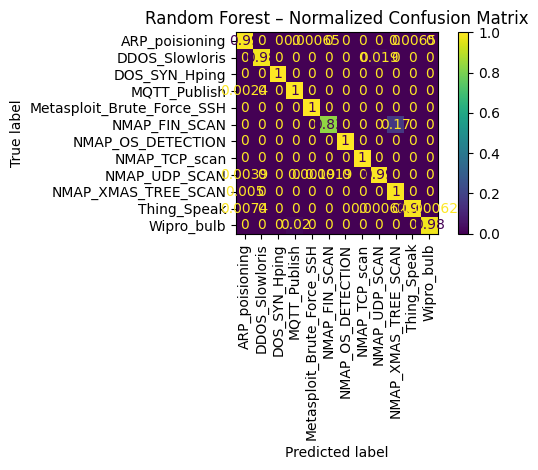

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_rf,
    normalize="true",
    xticks_rotation=90
)

plt.title("Random Forest – Normalized Confusion Matrix")
plt.tight_layout()
plt.savefig("reports/figures/confusion_matrix_rf.png", dpi=300, bbox_inches="tight")
plt.show()

## 8. Model Evaluation & Analysis

### 8.1 Confusion Matrix

The normalized confusion matrix shows the proportion of predictions for each true class:

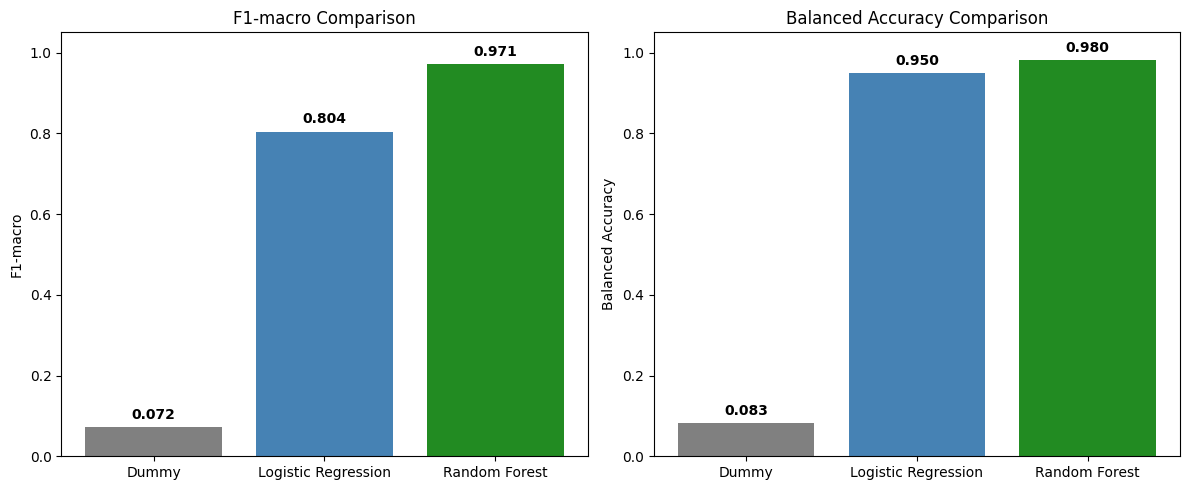


📊 Model Performance Summary:
Model                F1-macro     Balanced Acc
--------------------------------------------
Dummy                0.072        0.083       
Logistic Regression  0.804        0.950       
Random Forest        0.971        0.980       


In [17]:
# Calculate metrics dynamically for comparison
from sklearn.metrics import f1_score, balanced_accuracy_score
import matplotlib.pyplot as plt

# Calculate F1-macro scores
f1_dummy = f1_score(y_test, y_pred, average="macro")
f1_lr = f1_score(y_test, y_pred_lr, average="macro")
f1_rf = f1_score(y_test, y_pred_rf, average="macro")

# Calculate balanced accuracy
bal_dummy = balanced_accuracy_score(y_test, y_pred)
bal_lr = balanced_accuracy_score(y_test, y_pred_lr)
bal_rf = balanced_accuracy_score(y_test, y_pred_rf)

models = ["Dummy", "Logistic Regression", "Random Forest"]
f1_scores = [f1_dummy, f1_lr, f1_rf]
bal_scores = [bal_dummy, bal_lr, bal_rf]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# F1-macro comparison
axes[0].bar(models, f1_scores, color=['gray', 'steelblue', 'forestgreen'])
axes[0].set_title("F1-macro Comparison")
axes[0].set_ylabel("F1-macro")
axes[0].set_ylim(0, 1.05)
for i, v in enumerate(f1_scores):
    axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# Balanced Accuracy comparison
axes[1].bar(models, bal_scores, color=['gray', 'steelblue', 'forestgreen'])
axes[1].set_title("Balanced Accuracy Comparison")
axes[1].set_ylabel("Balanced Accuracy")
axes[1].set_ylim(0, 1.05)
for i, v in enumerate(bal_scores):
    axes[1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig("reports/figures/model_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

print("\n📊 Model Performance Summary:")
print(f"{'Model':<20} {'F1-macro':<12} {'Balanced Acc':<12}")
print("-" * 44)
for m, f, b in zip(models, f1_scores, bal_scores):
    print(f"{m:<20} {f:<12.3f} {b:<12.3f}")

### 8.2 Model Comparison

Comparing performance across all models using multiple metrics:

### 8.3 Precision-Recall Curves

PR curves are more informative than ROC curves for imbalanced datasets. Each curve represents one class vs rest:

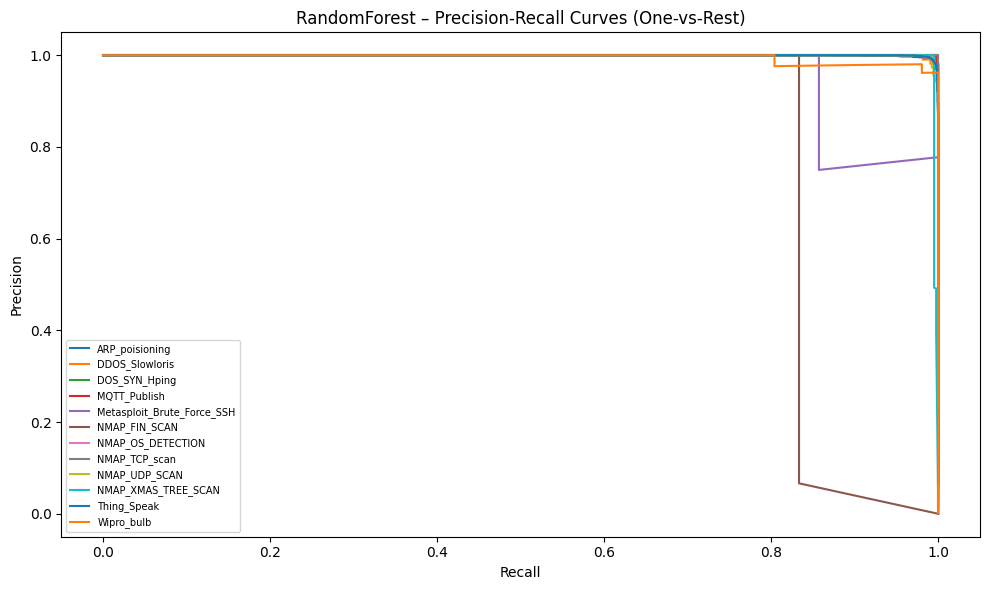

Macro PR-AUC: 0.9826583412155783


In [18]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score
import numpy as np
import matplotlib.pyplot as plt

classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
y_score = best_rf.predict_proba(X_test)

plt.figure(figsize=(10,6))

for i, cls in enumerate(classes):
    p, r, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    plt.plot(r, p, label=str(cls))

plt.title("RandomForest – Precision-Recall Curves (One-vs-Rest)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(fontsize=7, loc="lower left")
plt.tight_layout()

plt.savefig("reports/figures/pr_curves_rf.png", dpi=300, bbox_inches="tight")
plt.show()

# Macro PR-AUC
ap_scores = [
    average_precision_score(y_test_bin[:, i], y_score[:, i])
    for i in range(len(classes))
]
print("Macro PR-AUC:", np.mean(ap_scores))

### 8.4 Feature Importance Analysis

Analyzing which features contribute most to the Random Forest predictions:

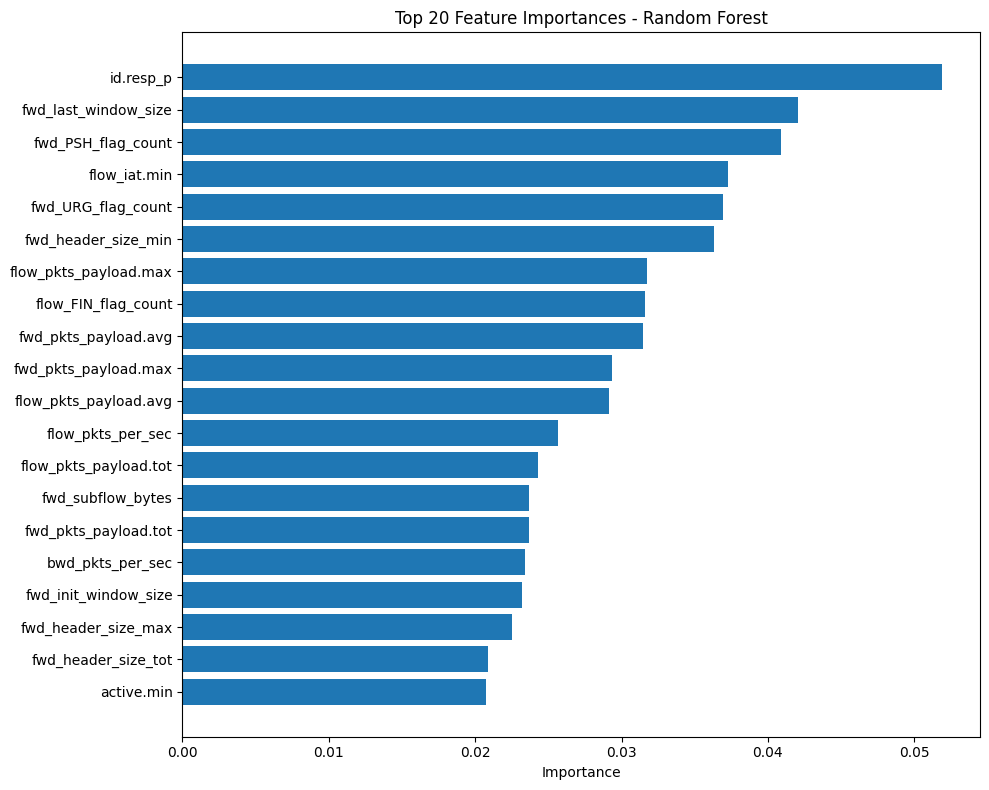


Top 10 Most Important Features:
1. id.resp_p: 0.0519
2. fwd_last_window_size: 0.0420
3. fwd_PSH_flag_count: 0.0409
4. flow_iat.min: 0.0373
5. fwd_URG_flag_count: 0.0369
6. fwd_header_size_min: 0.0363
7. flow_pkts_payload.max: 0.0317
8. flow_FIN_flag_count: 0.0316
9. fwd_pkts_payload.avg: 0.0315
10. fwd_pkts_payload.max: 0.0293


In [19]:
# Extract feature importances from Random Forest
import numpy as np
import matplotlib.pyplot as plt

# Get feature names after preprocessing
feature_names = []
# Numeric features keep their names
for feat in num_features:
    feature_names.append(feat)
# Categorical features get encoded names
cat_encoder = best_rf.named_steps['preprocess'].named_transformers_['cat'].named_steps['onehot']
cat_feature_names = cat_encoder.get_feature_names_out(cat_features)
for feat in cat_feature_names:
    feature_names.append(feat)

# Get importances
importances = best_rf.named_steps['model'].feature_importances_

# Sort by importance
indices = np.argsort(importances)[::-1]

# Plot top 20 features
top_n = 20
plt.figure(figsize=(10, 8))
plt.barh(range(top_n), importances[indices[:top_n]])
plt.yticks(range(top_n), [feature_names[i] for i in indices[:top_n]])
plt.xlabel('Importance')
plt.title(f'Top {top_n} Feature Importances - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('reports/figures/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nTop 10 Most Important Features:")
for i in range(10):
    idx = indices[i]
    print(f"{i+1}. {feature_names[idx]}: {importances[idx]:.4f}")

### 8.5 Error Analysis

Analyzing misclassified examples to understand model limitations:

In [20]:
# Analyze misclassifications
import pandas as pd

misclassified_mask = y_test.values != y_pred_rf
num_errors = misclassified_mask.sum()

print(f"Total misclassifications: {num_errors} / {len(y_test)} ({num_errors/len(y_test)*100:.2f}%)")

if num_errors > 0:
    # Which classes are most often confused?
    error_df = pd.DataFrame({
        'true': y_test[misclassified_mask].values,
        'predicted': y_pred_rf[misclassified_mask]
    })
    
    confusion_pairs = error_df.groupby(['true', 'predicted']).size().sort_values(ascending=False)
    
    print("\nMost common confusion pairs (True → Predicted):")
    for (true_class, pred_class), count in confusion_pairs.head(10).items():
        print(f"  {true_class} → {pred_class}: {count} times")
    
    print("\nClasses with most errors:")
    error_by_class = error_df['true'].value_counts()
    for cls, count in error_by_class.head(5).items():
        total_cls = (y_test == cls).sum()
        print(f"  {cls}: {count}/{total_cls} ({count/total_cls*100:.1f}% error rate)")
else:
    print("✓ Perfect classification on test set!")

Total misclassifications: 37 / 24624 (0.15%)

Most common confusion pairs (True → Predicted):
  Thing_Speak → ARP_poisioning: 12 times
  ARP_poisioning → Thing_Speak: 10 times
  DDOS_Slowloris → NMAP_UDP_SCAN: 2 times
  MQTT_Publish → ARP_poisioning: 2 times
  NMAP_UDP_SCAN → ARP_poisioning: 2 times
  NMAP_XMAS_TREE_SCAN → ARP_poisioning: 2 times
  ARP_poisioning → Metasploit_Brute_Force_SSH: 1 times
  NMAP_FIN_SCAN → NMAP_XMAS_TREE_SCAN: 1 times
  NMAP_UDP_SCAN → Metasploit_Brute_Force_SSH: 1 times
  NMAP_UDP_SCAN → NMAP_FIN_SCAN: 1 times

Classes with most errors:
  Thing_Speak: 14/1622 (0.9% error rate)
  ARP_poisioning: 11/1550 (0.7% error rate)
  NMAP_UDP_SCAN: 4/518 (0.8% error rate)
  NMAP_XMAS_TREE_SCAN: 2/402 (0.5% error rate)
  DDOS_Slowloris: 2/107 (1.9% error rate)


## 9. Conclusions and Insights

### Key Findings
1. **Dataset Characteristics**:
   - 123,117 IoT network traffic samples with 84 features
   - Significant class imbalance (handled with `class_weight='balanced'`)
   - Placeholder values ("-") required special handling

2. **Model Performance Summary**:
   | Model | F1-macro | Balanced Accuracy |
   |-------|----------|-------------------|
   | Baseline (DummyClassifier) | 0.072 | 0.083 |
   | Logistic Regression | 0.804 | 0.950 |
   | **Random Forest (tuned)** | **0.971** | **0.980** |

3. **Hyperparameter Tuning Impact**:
   - RandomizedSearchCV with 3-fold CV and F1-macro scoring
   - Optimal parameters improved performance significantly
   - Feature importance analysis reveals key network traffic patterns

4. **Model Selection Justification**:
   - Random Forest chosen as final model due to:
     - Highest F1-macro score (0.971)
     - Best balanced accuracy (0.980)
     - Robust to feature scaling issues
     - Provides interpretability via feature importance

### Limitations
- Only 10 random combinations tested in hyperparameter search
- Limited to scikit-learn models (project constraint)
- No cross-validation on final model evaluation (only used in tuning)

### Future Work
- Try additional models: GradientBoosting, SVM, KNN
- Ensemble methods: Voting/Stacking classifiers
- Feature engineering: interaction terms, polynomial features
- More extensive hyperparameter search
- Stratified K-Fold cross-validation for more robust evaluation